# 6 可视化分析

可视化分析包括特征图可视化以及类似 Grad CAM 等可视化分析手段。不过由于 MMDetection 中还没有实现，我们可以直接采用 MMYOLO 中提供的功能和脚本。MMYOLO 是基于 MMDetection 开发，并且此案有了统一的代码组织形式，因此 MMDetection 配置可以直接在 MMYOLO 中使用，无需更改配置。

## MMYOLO 环境和依赖安装

In [1]:
import os
os.chdir('mmdetection')
os.getcwd()

'/root/code/mmdetection'

In [2]:
!pwd
%cd ../
!rm -rf mmyolo
# 为了防止后续更新导致的可能无法运行，特意新建了 tutorials 分支
!git clone -b tutorials https://github.com/open-mmlab/mmyolo.git 
%cd mmyolo


/root/code/mmdetection
/root/code
Cloning into 'mmyolo'...
remote: Enumerating objects: 4898, done.
remote: Counting objects: 100% (289/289), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 4898 (delta 122), reused 230 (delta 112), pack-reused 4609
Receiving objects: 100% (4898/4898), 3.75 MiB | 5.70 MiB/s, done.
Resolving deltas: 100% (3011/3011), done.
/root/code/mmyolo


In [3]:
%pip install -e .
# mim install mmyolo
!pwd

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Obtaining file:///root/code/mmyolo
  Running setup.py develop for mmyolo
Note: you may need to restart the kernel to use updated packages.
/root/code/mmyolo


## 特征图可视化

MMYOLO 中，将使用 MMEngine 提供的 `Visualizer` 可视化器进行特征图可视化，其具备如下功能：

- 支持基础绘图接口以及特征图可视化。
- 支持选择模型中的不同层来得到特征图，包含 `squeeze_mean` ， `select_max` ， `topk` 三种显示方式，用户还可以使用 `arrangement` 自定义特征图显示的布局方式。

你可以调用 `demo/featmap_vis_demo.py` 来简单快捷地得到可视化结果，为了方便理解，将其主要参数的功能梳理如下：

- `img`：选择要用于特征图可视化的图片，支持单张图片或者图片路径列表。

- `config`：选择算法的配置文件。

- `checkpoint`：选择对应算法的权重文件。

- `--out-file`：将得到的特征图保存到本地，并指定路径和文件名。

- `--device`：指定用于推理图片的硬件，`--device cuda：0`  表示使用第 1 张 GPU 推理，`--device cpu` 表示用 CPU 推理。

- `--score-thr`：设置检测框的置信度阈值，只有置信度高于这个值的框才会显示。

- `--preview-model`：可以预览模型，方便用户理解模型的特征层结构。

- `--target-layers`：对指定层获取可视化的特征图。

  - 可以单独输出某个层的特征图，例如： `--target-layers backbone` ,  `--target-layers neck` ,  `--target-layers backbone.stage4` 等。
  - 参数为列表时，也可以同时输出多个层的特征图，例如： `--target-layers backbone.stage4 neck` 表示同时输出 backbone 的 stage4 层和 neck 的三层一共四层特征图。

- `--channel-reduction`：输入的 Tensor 一般是包括多个通道的，`channel_reduction` 参数可以将多个通道压缩为单通道，然后和图片进行叠加显示，有以下三个参数可以设置：

  - `squeeze_mean`：将输入的 C 维度采用 mean 函数压缩为一个通道，输出维度变成 (1, H, W)。
  - `select_max`：将输入先在空间维度 sum，维度变成 (C, )，然后选择值最大的通道。
  - `None`：表示不需要压缩，此时可以通过 `topk` 参数可选择激活度最高的 `topk` 个特征图显示。

- `--topk`：只有在 `channel_reduction` 参数为 `None` 的情况下， `topk` 参数才会生效，其会按照激活度排序选择 `topk` 个通道，然后和图片进行叠加显示，并且此时会通过 `--arrangement` 参数指定显示的布局，该参数表示为一个数组，两个数字需要以空格分开，例如： `--topk 5 --arrangement 2 3` 表示以 `2行 3列` 显示激活度排序最高的 5 张特征图， `--topk 7 --arrangement 3 3` 表示以 `3行 3列` 显示激活度排序最高的 7 张特征图。

  - 如果 topk 不是 -1，则会按照激活度排序选择 topk 个通道显示。
  - 如果 topk = -1，此时通道 C 必须是 1 或者 3 表示输入数据是图片，否则报错提示用户应该设置 `channel_reduction` 来压缩通道。

- 考虑到输入的特征图通常非常小，函数默认将特征图进行上采样后方便进行可视化。

**注意：当图片和特征图尺度不一样时候，`draw_featmap` 函数会自动进行上采样对齐。如果你的图片在推理过程中前处理存在类似 Pad 的操作此时得到的特征图也是 Pad 过的，那么直接上采样就可能会出现不对齐问题。**


In [3]:
import os
os.chdir('mmdetection')
os.getcwd()

'/root/code/mmdetection'

In [5]:
import cv2

img = cv2.imread('balloon_dataset/balloon_test.png')

print(img.shape)

# h,w=img.shape[:2]
# resized_img = cv2.resize(img, (640, 640))
# cv2.imwrite('mmdetection/balloon_dataset/balloon_resize.jpg', resized_img)

(266, 400, 3)


False

In [6]:
import os
os.chdir('mmyolo')
os.getcwd()

'/root/code/mmyolo'

**1. 可视化 backbone 输出的 3 个通道**

In [7]:
!python demo/featmap_vis_demo.py \
      ../mmdetection/balloon_dataset/balloon_test.png \
      ../mmdetection/balloon_dataset/balloon_rtmdet.py \
      ../mmdetection/work_dirs/balloon_rtmdet/best_coco/bbox_mAP_epoch_180.pth \
      --target-layers backbone  \
      --channel-reduction squeeze_mean

Loads checkpoint by local backend from path: ../mmdetection/work_dirs/balloon_rtmdet/best_coco/bbox_mAP_epoch_180.pth
06/11 09:24:25 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.
[                                                  ] 0/1, elapsed: 0s, ETA:/root/miniconda3/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/root/code/mmdetection/mmdet/visualization/palette.py:90: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor divis

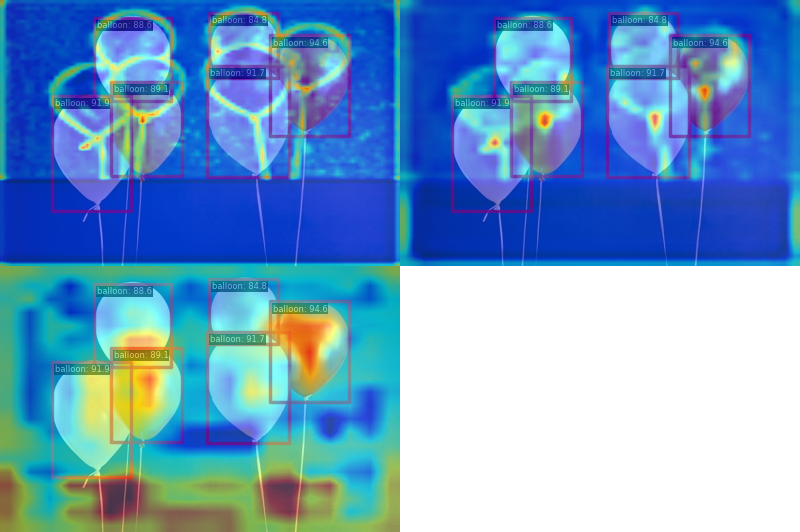

In [8]:
from PIL import Image
Image.open('output/balloon_test.png')    

**2. 可视化 neck 输出的 3 个通道**

In [11]:
!python demo/featmap_vis_demo.py \
      ../mmdetection/balloon_dataset/balloon_test.png \
      ../mmdetection/balloon_dataset/balloon_rtmdet.py \
      ../mmdetection/work_dirs/balloon_rtmdet/best_coco/bbox_mAP_epoch_180.pth  \
      --target-layers neck  \
      --channel-reduction squeeze_mean

Loads checkpoint by local backend from path: ../mmdetection/work_dirs/balloon_rtmdet/best_coco/bbox_mAP_epoch_180.pth
06/11 09:25:29 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.
[                                                  ] 0/1, elapsed: 0s, ETA:/root/miniconda3/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/root/code/mmdetection/mmdet/visualization/palette.py:90: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor divis

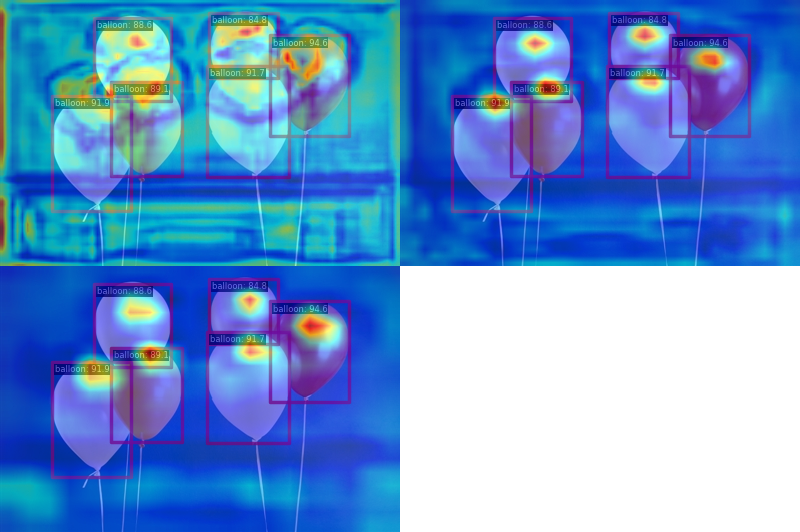

In [12]:
Image.open('output/balloon_test.png')     

## Grad-Based CAM 可视化

由于目标检测的特殊性，这里实际上可视化的并不是 CAM 而是 Grad Box AM。使用前需要先安装 grad-cam 库


In [13]:
!pip install "grad-cam"

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 7.8 MB 14.7 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38241 sha256=8ddb1cec281d932a74c99a1953e99322aa0b236997ee06fccbc73b688626b570
  Stored in directory: /root/.cache/pip/wheels/6c/16/cb/1f4064fc8846c1cd9d029e2561bd809dab8eb6da34f51a1d03
Successfully built grad-cam


**(a) 查看 neck 输出的最小输出特征图的 Grad CAM**

In [14]:
!python demo/boxam_vis_demo.py \
      ../mmdetection/balloon_dataset/balloon_test.png \
      ../mmdetection/balloon_dataset/balloon_rtmdet.py \
      ../mmdetection/work_dirs/balloon_rtmdet/best_coco/bbox_mAP_epoch_180.pth  \
      --target-layer neck.out_convs[2]    

The algorithm currently used is rtmdet
Loads checkpoint by local backend from path: ../mmdetection/work_dirs/balloon_rtmdet/best_coco/bbox_mAP_epoch_180.pth
[                                                  ] 0/1, elapsed: 0s, ETA:/root/miniconda3/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/root/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 6.3 task/s, elapsed: 0s, ETA:     0sAll done!
Results have been saved at /root/code/mmyolo/ou

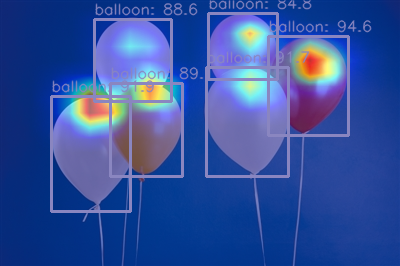

In [15]:
Image.open('output/balloon_test.png')     

**(b) 查看 neck 输出的最大输出特征图的 Grad CAM**

In [18]:
!python demo/boxam_vis_demo.py \
      ../mmdetection/balloon_dataset/balloon_test.png \
      ../mmdetection/balloon_dataset/balloon_rtmdet.py \
      ../mmdetection/work_dirs/balloon_rtmdet/best_coco/bbox_mAP_epoch_180.pth  \
      --target-layer neck.out_convs[0]  

The algorithm currently used is rtmdet
Loads checkpoint by local backend from path: ../mmdetection/work_dirs/balloon_rtmdet/best_coco/bbox_mAP_epoch_180.pth
[                                                  ] 0/1, elapsed: 0s, ETA:/root/miniconda3/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/root/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 6.4 task/s, elapsed: 0s, ETA:     0sAll done!
Results have been saved at /root/code/mmyolo/ou

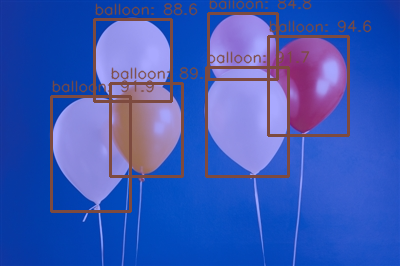

In [19]:
Image.open('output/balloon_test.png')     